In [3]:
%pip install seaborn
%pip install torchsampler

     -------------------------------------- 288.2/288.2 kB 3.0 MB/s eta 0:00:00
     ---------------------------------------- 10.4/10.4 MB 5.5 MB/s eta 0:00:00
     ---------------------------------------- 7.2/7.2 MB 5.2 MB/s eta 0:00:00
     ---------------------------------------- 14.6/14.6 MB 6.2 MB/s eta 0:00:00
     -------------------------------------- 965.4/965.4 kB 6.1 MB/s eta 0:00:00
     ---------------------------------------- 2.5/2.5 MB 7.2 MB/s eta 0:00:00
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)
  Using cached pyparsing-3.0.9-py3-none-any.whl (98 kB)
     -------------------------------------- 163.6/163.6 kB 3.3 MB/s eta 0:00:00
  Using cached kiwisolver-1.4.4-cp310-cp310-win_amd64.whl (55 kB)
     ------------------------------------- 498.1/498.1 kB 10.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


  Using cached torchsampler-0.1.2-py3-none-any.whl (5.6 kB)
     ---------------------------------------- 1.1/1.1 MB 2.3 MB/s eta 0:00:00
     -------------------------------------- 167.3/167.3 MB 2.0 MB/s eta 0:00:00
  Using cached requests-2.28.1-py3-none-any.whl (62 kB)
     ---------------------------------------- 61.5/61.5 kB 1.7 MB/s eta 0:00:00
     -------------------------------------- 140.6/140.6 kB 1.7 MB/s eta 0:00:00
     -------------------------------------- 155.3/155.3 kB 4.7 MB/s eta 0:00:00
  Using cached charset_normalizer-2.1.1-py3-none-any.whl (39 kB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
# all libraries used for efficientnet
import logging
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
from PIL import Image
from io import BytesIO
import os
import copy
import glob
import cv2
import seaborn as sns
import pandas as pd
import os
import argparse
import torchsampler
import pickle
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from torchsampler import ImbalancedDatasetSampler
from torchvision.models import resnet50, ResNet50_Weights
import io
import torch.optim as optim



In [2]:
# If CUDA is not available use CPU 
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


print(device)

cpu


In [3]:
# Data preprocessing
# Transforming, normalizing, flipping, resizing and converting to Tensor
# Mean and standard deviation for normalizing

# Dataset is split into three directory: train, val and test
data_means = [0.485, 0.456, 0.406]
data_stds = [0.229, 0.224, 0.225]
data_transform = {
    'train': transforms.Compose([
        transforms.Resize((240, 240)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(data_means, data_stds),

  
    ]),
    'val': transforms.Compose([
        transforms.Resize((240, 240)),
        transforms.ToTensor(),
        transforms.Normalize(data_means, data_stds)

  
    ]),
    'test': transforms.Compose([
        transforms.Resize((240, 240)),
        transforms.ToTensor(),
        transforms.Normalize(data_means, data_stds),
  
    ]),
}

In [4]:
# defines the dataset directory
data_dir = 'wound_dataset'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transform[x])
                  for x in ['train', 'val', 'test']}

# trainloader and using an Imbalanced data sampler to balance it out
train_loader = torch.utils.data.DataLoader(
    image_datasets['train'],
    sampler=ImbalancedDatasetSampler(image_datasets['train'])
)
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], sampler = ImbalancedDatasetSampler(image_datasets[x]), batch_size=16,num_workers=3)
              for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val','test']}
# defining the classes from the dataset
class_names = image_datasets['train'].classes

In [22]:
# Using pretrained model efficientnet 
model_ft = models.efficientnet_b1(pretrained=True)
num_ftrs = model_ft.classifier[1].in_features

# Here the size of each output sample is set to 4
model_ft.classifier[1] = nn.Linear(num_ftrs, 4)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Set the learning rate to 0.0001 and using the adam optimizer
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.0001)

# Decay learning rate by a factor of 0.3 every 10 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.3)

In [23]:
# train model function which takes the parameters of the model, criterion, optimizer, scheduler and the number of epochs
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()
    # Deep copy the model
    best_model = copy.deepcopy(model.state_dict()) 
    # Current best accuracy which will be replaced
    best_acc = 0.0
    # How many iterations of training
    for epoch in range(num_epochs): 
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        last_loss = 1000
        patience = 2
        triggertimes = 0
        # Each epoch returns training and validation
        for phase in ['train', 'val']:
            if phase == 'train':
                # Set model to training mode
                model.train()  
            else:
                # Set model to validation mode
                model.eval()   
            #Initialize the loss
            running_loss = 0.0 
            #Initialize the correct point
            running_corrects = 0 

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                # forward to the dataset
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    # backward from the dataset
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model if the accuracy is higher than the previous epoch
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    # Prints the best validation accuracy and the lenght of the training
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # Load best  weights and biases for the model to be exported
    model.load_state_dict(best_model)
    return model

In [24]:
# Call the train_model function and its defined hyperparameters
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=20)

Epoch 0/19
----------
train Loss: 1.3420 Acc: 0.3458
val Loss: 1.2699 Acc: 0.4750

Epoch 1/19
----------
train Loss: 1.1434 Acc: 0.6042
val Loss: 1.1454 Acc: 0.5750

Epoch 2/19
----------
train Loss: 1.0171 Acc: 0.7542
val Loss: 0.9798 Acc: 0.6500

Epoch 3/19
----------
train Loss: 0.8752 Acc: 0.8167
val Loss: 0.9506 Acc: 0.6125

Epoch 4/19
----------
train Loss: 0.6934 Acc: 0.8542
val Loss: 0.8447 Acc: 0.7500

Epoch 5/19
----------
train Loss: 0.5671 Acc: 0.8792
val Loss: 0.8590 Acc: 0.6750

Epoch 6/19
----------
train Loss: 0.4608 Acc: 0.9167
val Loss: 0.7684 Acc: 0.7625

Epoch 7/19
----------
train Loss: 0.3896 Acc: 0.9167
val Loss: 0.7468 Acc: 0.8000

Epoch 8/19
----------
train Loss: 0.2748 Acc: 0.9583
val Loss: 0.6088 Acc: 0.7750

Epoch 9/19
----------
train Loss: 0.2451 Acc: 0.9625
val Loss: 0.7124 Acc: 0.7625

Epoch 10/19
----------
train Loss: 0.2502 Acc: 0.9375
val Loss: 0.8463 Acc: 0.7500

Epoch 11/19
----------
train Loss: 0.2296 Acc: 0.9542
val Loss: 0.8159 Acc: 0.7125

Ep

Text(0.5, 80.7222222222222, 'Predicted label')

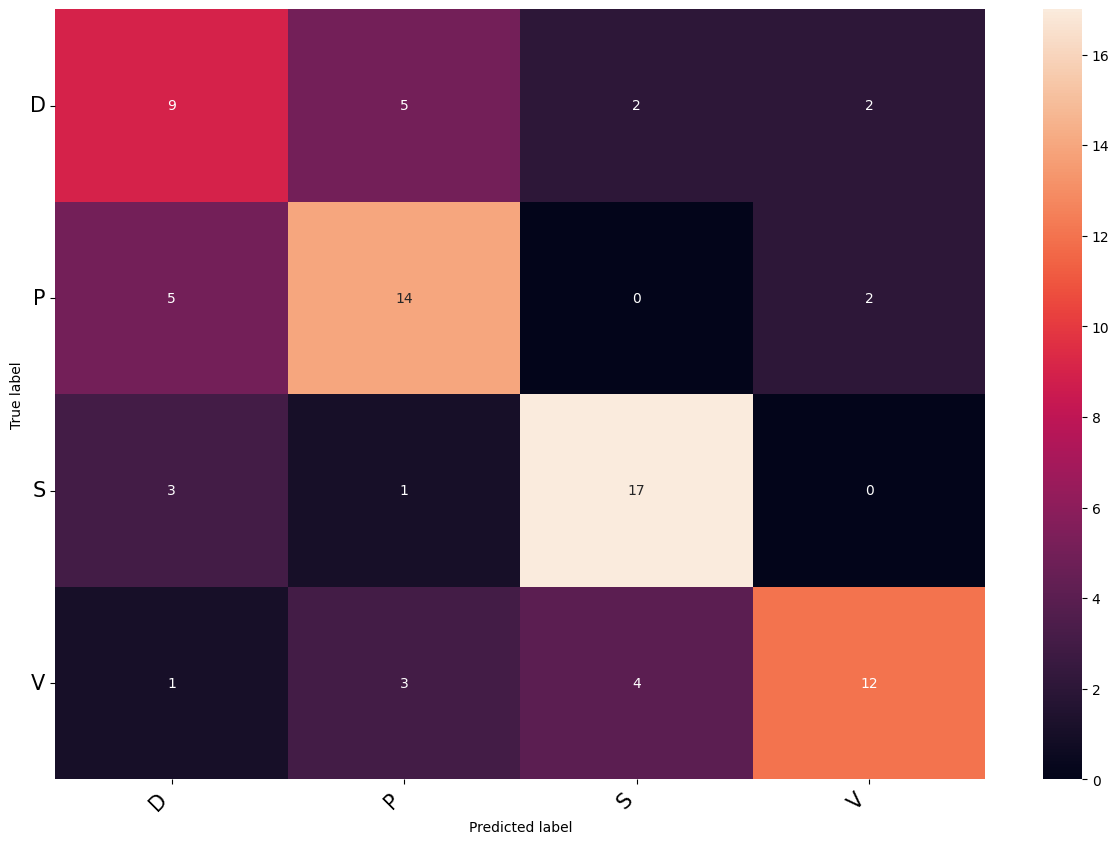

In [26]:
cm_classes = 4
confusion_matrix = np.zeros((cm_classes, cm_classes))
with torch.no_grad():
    #Loads dataset
    for i, (inputs, truelbl) in enumerate(dataloaders['val']):
        # The validation dataset that will be used as the input
        inputs = inputs.to(device)
        # The actual class label
        truelbl = truelbl.to(device)
        #model prediction
        outputs = model_ft(inputs)

        _, preds = torch.max(outputs, 1)
        for t, p in zip(truelbl.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

# to output the matrix size
plt.figure(figsize=(15,10))
#defining the class names to the labels
class_names = label_classes

df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names).astype(int)
#using a heatmap to get better graphical analysis
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

#True label
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
plt.ylabel('True label')

#pred lable
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
plt.xlabel('Predicted label')
plt.savefig('efficient_val_cm.png')


Text(0.5, 80.7222222222222, 'Predicted label')

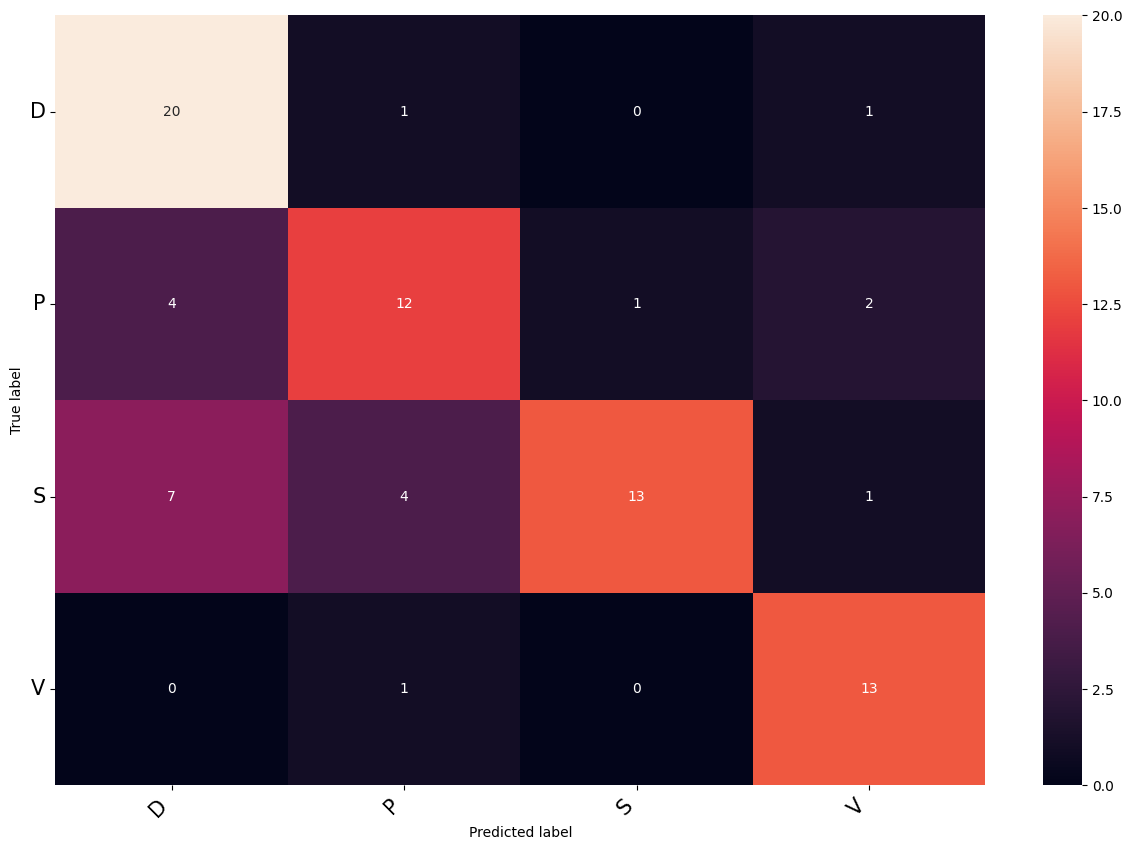

In [27]:
cm_classes = 4
confusion_matrix = np.zeros((cm_classes, cm_classes))
with torch.no_grad():
    #Loads dataset
    for i, (inputs, truelbl) in enumerate(dataloaders['test']):
        # The test dataset that will be used as the input
        inputs = inputs.to(device)
        # The actual class label
        truelbl = truelbl.to(device)
        #model prediction
        outputs = model_ft(inputs)

        _, preds = torch.max(outputs, 1)
        for t, p in zip(truelbl.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

# to output the matrix size
plt.figure(figsize=(15,10))
#defining the class names to the labels
class_names = label_classes

df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names).astype(int)
#using a heatmap to get better graphical analysis
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

#True label
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
plt.ylabel('True label')

#pred lable
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
plt.xlabel('Predicted label')
plt.savefig('efficient_val_cm.png')


In [16]:
# saves the model with the best accuracy for it to be inferenced
torch.save(model_ft.state_dict(), 'efficientnet.pt')
pickle.dump(model_ft, open('efficientnet.pkl','wb'))